In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
jpy_files = ['JPYUSD100_2016_5min_b0.csv','JPYUSD100_2017_5min_b0.csv','JPYUSD100_2018_5min_b0.csv','JPYUSD100_2019_5min_b0.csv']
eur_files = ['EURUSD_2016_5min_b0.csv','EURUSD_2017_5min_b0.csv','EURUSD_2018_5min_b0.csv','EURUSD_2019_5min_b0.csv']
gbp_files = ['GBPUSD_2016_5min_b0.csv','GBPUSD_2017_5min_b0.csv','GBPUSD_2018_5min_b0.csv','GBPUSD_2019_5min_b0.csv']

In [3]:
# reduce memory usage by converting to proper data types
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
def concat_curr_files(c_files):
    usecols=['ctime','mean','std','bar_len','bar_spearman','bar_log_r','first_r','max_r','min_r','last_r','bar_quantile_25_r','bar_quantile_75_r']
    df_full = df = pd.DataFrame(columns = usecols)
    for data_file in c_files:
        df = pd.read_csv(f'fx_data/{data_file}', usecols=usecols)
        df_full = pd.concat([df_full, df])

    # time column to index
    df_full['ctime']  = pd.to_datetime(df_full['ctime'])
    df_full = df_full.set_index('ctime')

    # drop weekends
    df_full = df_full.loc[df_full['bar_len']>0]

    return df_full

In [5]:
# fx dataframes
df_jpy = concat_curr_files(jpy_files)
df_eur = concat_curr_files(eur_files)
df_gbp = concat_curr_files(gbp_files)

In [6]:
df_jpy = reduce_mem_usage(df_jpy)
df_eur = reduce_mem_usage(df_eur)
df_gbp = reduce_mem_usage(df_gbp)

Memory usage of dataframe is 27.36 MB
Memory usage after optimization is: 8.55 MB
Decreased by 68.8%
Memory usage of dataframe is 27.36 MB
Memory usage after optimization is: 8.55 MB
Decreased by 68.8%
Memory usage of dataframe is 27.36 MB
Memory usage after optimization is: 8.55 MB
Decreased by 68.8%


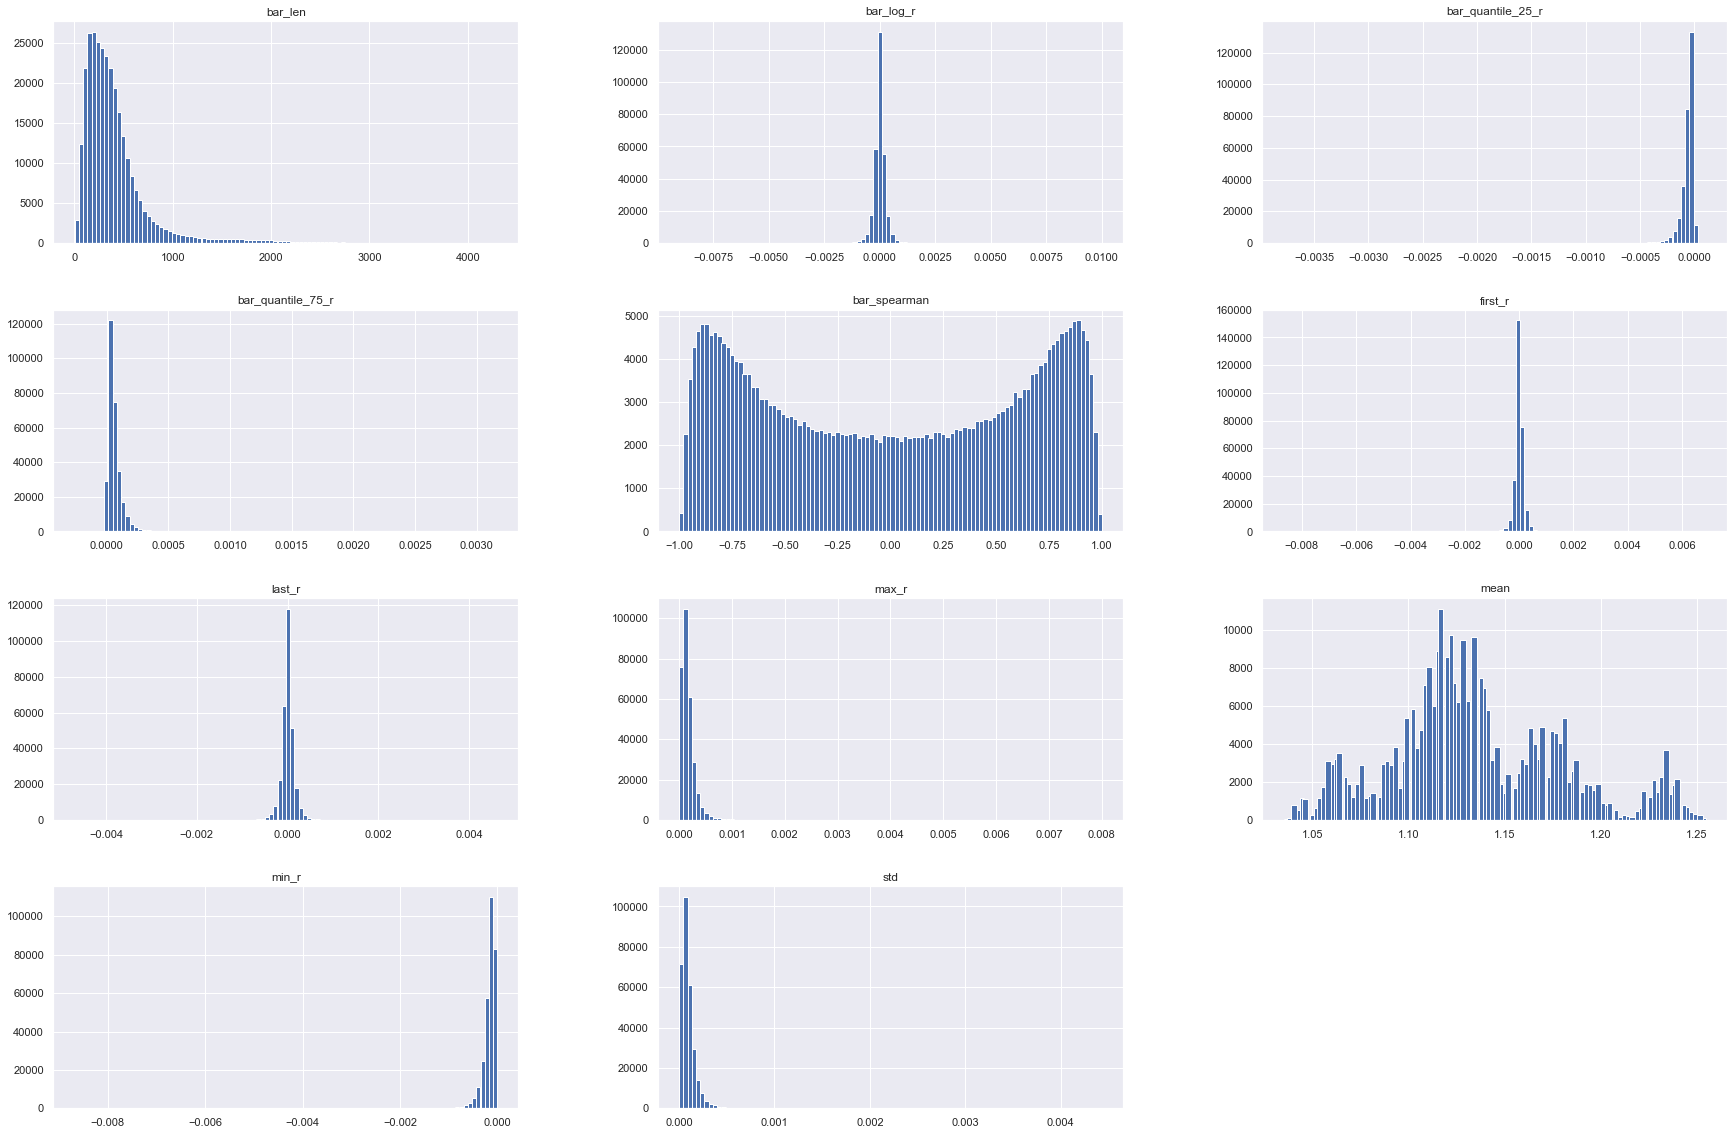

In [7]:
df_eur.hist(figsize=(30, 20), bins=100);

In [8]:
# set hierarchical index
df_eur.columns = pd.MultiIndex.from_product([['c_eur'], df_eur.columns])
df_gbp.columns = pd.MultiIndex.from_product([['c_gbp'], df_gbp.columns])
df_jpy.columns = pd.MultiIndex.from_product([['c_jpy'], df_jpy.columns])

In [9]:
# make the currency dataframe
df_curr = pd.concat([df_eur, df_gbp, df_jpy], axis=1, join='inner')

In [10]:
# time features
df_curr['month'] = df_curr.index.month
df_curr['dow'] = df_curr.index.dayofweek
df_curr['hour'] = df_curr.index.hour

In [11]:
df_curr.columns

MultiIndex([('c_eur',              'mean'),
            ('c_eur',               'std'),
            ('c_eur',           'bar_len'),
            ('c_eur',      'bar_spearman'),
            ('c_eur',         'bar_log_r'),
            ('c_eur',           'first_r'),
            ('c_eur',             'max_r'),
            ('c_eur',             'min_r'),
            ('c_eur',            'last_r'),
            ('c_eur', 'bar_quantile_25_r'),
            ('c_eur', 'bar_quantile_75_r'),
            ('c_gbp',              'mean'),
            ('c_gbp',               'std'),
            ('c_gbp',           'bar_len'),
            ('c_gbp',      'bar_spearman'),
            ('c_gbp',         'bar_log_r'),
            ('c_gbp',           'first_r'),
            ('c_gbp',             'max_r'),
            ('c_gbp',             'min_r'),
            ('c_gbp',            'last_r'),
            ('c_gbp', 'bar_quantile_25_r'),
            ('c_gbp', 'bar_quantile_75_r'),
            ('c_jpy',           

In [12]:
def add_onehotencode_columns(df, source_names, top_names=None):
    if top_names == None: top_names=source_names
    info = zip(source_names, top_names)
    for source, top in info:
        df_aux = pd.get_dummies(df[source],prefix='', drop_first=False)
        df_aux.columns = pd.MultiIndex.from_product([[top], df_aux.columns])
        df = pd.concat([df, df_aux], axis=1, join='inner')
    return df

In [13]:
df_curr = add_onehotencode_columns(df_curr, ['month', 'dow', 'hour'])

In [14]:
# drop not encoded columns
df_curr = df_curr.drop(columns=[('month',''), ('dow',''), ('hour','')])

In [15]:
df_curr.columns

MultiIndex([('c_eur',              'mean'),
            ('c_eur',               'std'),
            ('c_eur',           'bar_len'),
            ('c_eur',      'bar_spearman'),
            ('c_eur',         'bar_log_r'),
            ('c_eur',           'first_r'),
            ('c_eur',             'max_r'),
            ('c_eur',             'min_r'),
            ('c_eur',            'last_r'),
            ('c_eur', 'bar_quantile_25_r'),
            ('c_eur', 'bar_quantile_75_r'),
            ('c_gbp',              'mean'),
            ('c_gbp',               'std'),
            ('c_gbp',           'bar_len'),
            ('c_gbp',      'bar_spearman'),
            ('c_gbp',         'bar_log_r'),
            ('c_gbp',           'first_r'),
            ('c_gbp',             'max_r'),
            ('c_gbp',             'min_r'),
            ('c_gbp',            'last_r'),
            ('c_gbp', 'bar_quantile_25_r'),
            ('c_gbp', 'bar_quantile_75_r'),
            ('c_jpy',           

In [16]:
df_news = pd.read_csv('news_data/news_data_tight.csv')
df_news = reduce_mem_usage(df_news)

Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.15 MB
Decreased by 34.0%


In [17]:
# time column to index
df_news['ctime']  = pd.to_datetime(df_news['Date'])
df_news = df_news.set_index('ctime')
df_news = df_news.drop(columns=['Date'])

In [18]:
# keep our final news features
# will drop Previous later
df_news = df_news[['Event', 'Currency', 'Actual', 'Previous', 'change', 'surp']]

In [19]:
df_news.isnull().any()

Event       False
Currency    False
Actual      False
Previous    False
change      False
surp        False
dtype: bool

In [20]:
event_types = list(df_news['Event'].unique())
print(event_types)
print('Number of event types: ', len(event_types))

['france markit manufacturing pmi', 'germany markit manufacturing pmi', 'united states ism prices paid', 'united states ism manufacturing pmi', 'germany unemployment change', 'european monetary union consumer price index  core yoy', 'european monetary union consumer price index yoy', 'united states adp employment change', 'united states trade balance', 'united states ism nonmanufacturing pmi', 'usd event', 'united states initial jobless claims', 'united states unemployment rate', 'united states nonfarm payrolls', 'japan current account nsa', 'jpy speech', 'gbp speech', 'united states jolts job openings', 'eur event', 'united kingdom boe mpc vote hike', 'united kingdom boe mpc vote unchanged', 'united kingdom boe mpc vote cut', 'united kingdom boe asset purchase facility', 'united kingdom boe interest rate decision', 'gbp event', 'united states retail sales ex autos mom', 'united states retail sales mom', 'united states reutersmichigan consumer sentiment index', 'united states building 

In [21]:
# standardize previous consensus and actual for every event type separately
# df[['Previous','Consensus','Actual']].loc[df['Event']=='united states retail sales mom'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [22]:
# two possible ways to go with news data
# 1: standardize Actual/change/surp for every event type separately, and onehotencode the events -> less features
# 2: onehotencode Actual/change/surp based on Event, then onehotencode event -> more features, but we will condense this by embedding layers
# we will go with 2.

In [23]:
df_news

,Event,Currency,Actual,Previous,change,surp
ctime,,,,,,
2016-01-04 08:50:00,france markit manufacturing pmi,EUR,51.406250,51.593750,-0.199951,-0.199951
2016-01-04 08:55:00,germany markit manufacturing pmi,EUR,53.187500,53.000000,0.199951,0.199951
2016-01-04 15:00:00,united states ism prices paid,USD,33.500000,35.500000,-2.000000,-1.700195
2016-01-04 15:00:00,united states ism manufacturing pmi,USD,48.187500,48.593750,-0.399902,-0.799805
2016-01-05 08:55:00,germany unemployment change,EUR,14.000000,14.000000,0.000000,0.000000
...,...,...,...,...,...,...
2019-12-26 13:30:00,united states initial jobless claims,USD,222.000000,235.000000,-13.000000,-2.000000
2019-12-26 13:30:00,united states initial jobless claims 4week ave...,USD,228.000000,225.750000,2.250000,2.250000
2019-12-26 23:30:00,japan tokyo cpi ex fresh food yoy,JPY,0.799805,0.600098,0.199951,0.199951


In [24]:
df_news.columns = pd.MultiIndex.from_product([['raw'], df_news.columns])

In [25]:
# generate onehotencoded events for the events and the features
df_news = add_onehotencode_columns(df_news, [('raw','Currency'), ('raw','Event')], ['event_cur', 'event_exist'])

In [26]:
# add the onehotencoded features with NaN
eho_tops = ['actual_ohe', 'previous_ohe', 'surprise_ohe', 'change_ohe']
for eho in eho_tops:
    df_aux = df_news['event_exist'].replace(0, np.nan)
    df_aux.columns = pd.MultiIndex.from_product([[eho], df_aux.columns])
    df_news = pd.concat([df_news, df_aux], axis=1, sort=False)

In [28]:
len(list(df_news.columns))

390

In [29]:
# update the onehotencoded features
df_news['actual_ohe'] = df_news['actual_ohe'].mul(df_news['raw', 'Actual'],axis=0)
df_news['previous_ohe'] = df_news['previous_ohe'].mul(df_news['raw', 'Previous'],axis=0)
df_news['change_ohe'] = df_news['change_ohe'].mul(df_news['raw', 'change'],axis=0)
df_news['surprise_ohe'] = df_news['surprise_ohe'].mul(df_news['raw', 'surp'],axis=0)

In [31]:
# we have datetimes with multiple events
df_news.index.value_counts()

2019-11-27 13:30:00    9
2017-11-02 12:00:00    8
2019-07-25 12:30:00    8
2017-09-14 11:00:00    7
2017-05-11 11:00:00    7
                      ..
2017-05-22 14:30:00    1
2019-05-22 08:30:00    1
2019-03-12 19:00:00    1
2018-04-11 11:00:00    1
2016-12-27 15:00:00    1
Name: ctime, Length: 2549, dtype: int64

In [32]:
# sum events of the same type, onehotencoded columns are ok, raw columns will have some false sums
# without min_count=1 sum of NaNs would be zero, we don't want that, zero is a valid number, so sum of Nans shouldn't produce zero
df_news = df_news.groupby(df_news.index).sum(min_count=1)

In [34]:
# drop original columns
df_news = df_news.drop(columns=['raw'])

C:\ProgramData\Anaconda3\envs\env_working\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [35]:
print(len(list(df_news.columns)))
list(df_news.columns)

384


orders'),
 ('event_exist', '_united states durable goods orders ex defense'),
 ('event_exist', '_united states durable goods orders ex transportation'),
 ('event_exist', '_united states existing home sales mom'),
 ('event_exist', '_united states fed interest rate decision'),
 ('event_exist', '_united states goods trade balance'),
 ('event_exist', '_united states gross domestic product annualized'),
 ('event_exist', '_united states gross domestic product price index'),
 ('event_exist', '_united states initial jobless claims'),
 ('event_exist', '_united states initial jobless claims 4week average'),
 ('event_exist', '_united states ism manufacturing pmi'),
 ('event_exist', '_united states ism nonmanufacturing pmi'),
 ('event_exist', '_united states ism prices paid'),
 ('event_exist', '_united states jolts job openings'),
 ('event_exist', '_united states michigan consumer sentiment index'),
 ('event_exist', '_united states new home sales mom'),
 ('event_exist', '_united states nondefense 

In [36]:
# build df with all data
df_full = pd.merge(df_curr, df_news, how='left', left_index=True, right_index=True)

In [37]:
# enable garbage collection of old df-s
del df_curr
del df_news
del df_gbp
del df_eur
del df_jpy
del df_aux

In [38]:
df_full

c_eur                                           \
                         mean       std bar_len bar_spearman bar_log_r   
ctime                                                                    
2016-01-03 22:00:00  1.087891  0.000015    28.0    -0.737305 -0.000037   
2016-01-03 22:05:00  1.086914  0.000049   155.0    -0.181030 -0.000230   
2016-01-03 22:10:00  1.086914  0.000105   138.0    -0.460449 -0.000248   
2016-01-03 22:15:00  1.086914  0.000043   125.0     0.282227 -0.000028   
2016-01-03 22:20:00  1.086914  0.000148   115.0    -0.043121 -0.000120   
...                       ...       ...     ...          ...       ...   
2019-12-31 21:35:00  1.121094  0.000036    62.0    -0.800781 -0.000080   
2019-12-31 21:40:00  1.121094  0.000028    41.0    -0.141602 -0.000009   
2019-12-31 21:45:00  1.121094  0.000046   108.0     0.612793 -0.000018   
2019-12-31 21:50:00  1.121094  0.000046    97.0    -0.912598 -0.000143   
2019-12-31 21:55:00  1.121094  0.000131    91.0     0.075073  0.000294   

                                                                               \
                      first_r     max_r     min_r    last_r bar_quantile_25_r   
ctime                                                                           
2016-01-03 22:00:00  0.000030  0.000030 -0.000016 -0.000007         -0.000009   
2016-01-03 22:05:00  0.000081  0.000081 -0.000149 -0.000149         -0.000029   
2016-01-03 22:10:00  0.000203  0.000203 -0.000147 -0.000046         -0.000064   
2016-01-03 22:15:00 -0.000007  0.000057 -0.000108 -0.000035         -0.000007   
2016-01-03 22:20:00 -0.000144  0.000224 -0.000264 -0.000264         -0.000126   
...                       ...       ...       ...       ...               ...   
2019-12-31 21:35:00  0.000062  0.000062 -0.000036 -0.000018         -0.000027   
2019-12-31 21:40:00 -0.000027  0.000035 -0.000054 -0.000036         -0.000018   
2019-12-31 21:45:00  0.000029  0.000047 -0.000096  0.000011         -0.000024   
2019-12-31 21:50:00  0.000056  0.000092 -0.000122 -0.000086         -0.000015   
2019-12-31 21:55:00 -0.000033  0.000261 -0.000123  0.000261         -0.000078   

                     ...  \
                     ...   
ctime                ...   
2016-01-03 22:00:00  ...   
2016-01-03 22:05:00  ...   
2016-01-03 22:10:00  ...   
2016-01-03 22:15:00  ...   
2016-01-03 22:20:00  ...   
...                  ...   
2019-12-31 21:35:00  ...   
2019-12-31 21:40:00  ...   
2019-12-31 21:45:00  ...   
2019-12-31 21:50:00  ...   
2019-12-31 21:55:00  ...   

                                                                    change_ohe  \
                    _united states nondefense capital goods orders ex aircraft   
ctime                                                                            
2016-01-03 22:00:00                                                NaN           
2016-01-03 22:05:00                                                NaN           
2016-01-03 22:10:00                                                NaN           
2016-01-03 22:15:00                                                NaN           
2016-01-03 22:20:00                                                NaN           
...                                                                ...           
2019-12-31 21:35:00                                                NaN           
2019-12-31 21:40:00                                                NaN           
2019-12-31 21:45:00                                                NaN           
2019-12-31 21:50:00                                                NaN           
2019-12-31 21:55:00                                                NaN           

                                                     \
                    _united states nonfarm payrolls   
ctime                                                 
2016-01-03 22:00:00                             NaN   
2016-01-03 22:05:00                             NaN   
2016-01-03 22:10:00                

In [39]:
# replace currency with 0 where NaN
df_full['event_cur'] = df_full['event_cur'].fillna(0)
# replace event exist with 0 where NaN
df_full['event_exist'] = df_full['event_exist'].fillna(0)

# next two are hard to decide, could be ffill or 0
# will use 0 here, with a +- step counter between events of the same type the ffill could be better shoics
df_full['change_ohe'] = df_full['change_ohe'].fillna(0)
df_full['surprise_ohe'] = df_full['surprise_ohe'].fillna(0)

# with these methods we could continously input changing consensus data (what I don' have)

In [40]:
# replace NaN actuals with last known actual
df_full['actual_ohe'] = df_full['actual_ohe'].astype('float32').fillna(method='ffill')
# replace previous backward to fill the NaNs at the beginning of the actuals
df_full['previous_ohe'] = df_full['previous_ohe'].astype('float32').fillna(method='bfill')

In [41]:
# fill remaining actual NaNs
df_full['actual_ohe'] = df_full['actual_ohe'].fillna(df_full['previous_ohe'])

In [44]:
df_full = df_full.drop(columns='previous_ohe')

C:\ProgramData\Anaconda3\envs\env_working\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [46]:
top_level = list(df_full.columns.get_level_values(0).unique())
top_level

['c_eur',
 'c_gbp',
 'c_jpy',
 'month',
 'dow',
 'hour',
 'event_cur',
 'event_exist',
 'actual_ohe',
 'surprise_ohe',
 'change_ohe']

In [47]:
# we have some NaN, but few relative to the dataset
for top_h in top_level:
    print(top_h, '***********')
    print(df_full[top_h].isna().any().loc[df_full[top_h].isna().any()==True])
    print(df_full[top_h].isna().sum().loc[df_full[top_h].isna().sum()>0])

c_eur ***********
std             True
bar_spearman    True
dtype: bool
std              5
bar_spearman    44
dtype: int64
c_gbp ***********
std             True
bar_spearman    True
dtype: bool
std              8
bar_spearman    42
dtype: int64
c_jpy ***********
std             True
bar_spearman    True
dtype: bool
std             17
bar_spearman    74
dtype: int64
month ***********
Series([], dtype: bool)
Series([], dtype: int64)
dow ***********
Series([], dtype: bool)
Series([], dtype: int64)
hour ***********
Series([], dtype: bool)
Series([], dtype: int64)
event_cur ***********
Series([], dtype: bool)
Series([], dtype: int64)
event_exist ***********
Series([], dtype: bool)
Series([], dtype: int64)
actual_ohe ***********
Series([], dtype: bool)
Series([], dtype: int64)
surprise_ohe ***********
Series([], dtype: bool)
Series([], dtype: int64)
change_ohe ***********
Series([], dtype: bool)
Series([], dtype: int64)


In [48]:
# as we have only std and bar_spearman NaNs, it is reasonable to set them 0
df_full = df_full.fillna(0.0)

In [49]:
df_full.isnull().any().any()

False

In [54]:
df_full.to_csv('fx_with_news.csv', index=True)

In [58]:
df_back = pd.read_csv('fx_with_news.csv', header=[0,1], index_col=0)

In [56]:
df_back

Unnamed: 0_level_0  c_eur                                           \
         Unnamed: 0_level_1   mean       std bar_len bar_spearman bar_log_r   
0                     ctime    NaN       NaN     NaN          NaN       NaN   
1       2016-01-03 22:00:00  1.088  0.000015    28.0      -0.7373 -0.000037   
2       2016-01-03 22:05:00  1.087  0.000049   155.0      -0.1810 -0.000230   
3       2016-01-03 22:10:00  1.087  0.000105   138.0      -0.4604 -0.000248   
4       2016-01-03 22:15:00  1.087  0.000043   125.0       0.2822 -0.000028   
...                     ...    ...       ...     ...          ...       ...   
298825  2019-12-31 21:35:00  1.121  0.000036    62.0      -0.8010 -0.000080   
298826  2019-12-31 21:40:00  1.121  0.000028    41.0      -0.1416 -0.000009   
298827  2019-12-31 21:45:00  1.121  0.000046   108.0       0.6130 -0.000018   
298828  2019-12-31 21:50:00  1.121  0.000046    97.0      -0.9126 -0.000143   
298829  2019-12-31 21:55:00  1.121  0.000131    91.0       0.0751  0.000294   

                                                ...  \
         first_r     max_r     min_r    last_r  ...   
0            NaN       NaN       NaN       NaN  ...   
1       0.000030  0.000030 -0.000016 -0.000007  ...   
2       0.000081  0.000081 -0.000149 -0.000149  ...   
3       0.000202  0.000202 -0.000147 -0.000046  ...   
4      -0.000007  0.000057 -0.000108 -0.000035  ...   
...          ...       ...       ...       ...  ...   
298825  0.000062  0.000062 -0.000036 -0.000018  ...   
298826 -0.000027  0.000035 -0.000054 -0.000036  ...   
298827  0.000029  0.000047 -0.000096  0.000011  ...   
298828  0.000056  0.000092 -0.000122 -0.000086  ...   
298829 -0.000033  0.000261 -0.000122  0.000261  ...   

                                                       change_ohe  \
       _united states nondefense capital goods orders ex aircraft   
0                                                     NaN           
1                                                     0.0           
2                                                     0.0           
3                                                     0.0           
4                                                     0.0           
...                                                   ...           
298825                                                0.0           
298826                                                0.0           
298827                                                0.0           
298828                                                0.0           
298829                                                0.0           

                                        \
       _united states nonfarm payrolls   
0                                  NaN   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
...                                ...   
298825                             0.0   
298826                             0.0   
298827                             0.0   
298828                             0.0   
298829                             0.0   

                                                  \
       _united states retail sales control group   
0                                            NaN   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
...                                          ...   
298825                                       0.0   
298826                                       0.0   
298827                                       0.0   
298828                                       0.0   
298829                                       0.0   

                                                 \
       _united states retail sales ex autos mom   
0                                        

In [57]:
df_full.shape

(298829, 383)